## Reading in data available from the Oellrich, Walls et al. (2015) paper
The purpose of this notebook is to read in and do a preliminary analysis of the data that is present in the supplementary file of this paper. The dataset also needs to be converted to a standard set of columns containing information in a standard format.

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
import os
import warnings
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

sys.path.append("../../oats")
from oats.utils.utils import to_abbreviation
from oats.nlp.preprocess import concatenate_with_bar_delim
from oats.nlp.preprocess import other_delim_to_bar_delim
from oats.nlp.preprocess import remove_punctuation
from oats.nlp.preprocess import remove_enclosing_brackets

OUTPUT_DIR = "../data/reshaped_files"
mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Part 1: Phenotypic Text Data
This data contains the phenotype descriptions for dominant mutants of genes across six different plant species. The data is read in from a cleaned version that removed some small delimiter errors from the original dataset that is available as a supplemental file from that publication. The data itself is unchanged.

There are several columns that contain information about gene names and accessions. We need to know what type of information is in each in order to know which should be retained in the dataset we are preparing. We are interested in both gene names that should map to a specific accession (like cyp716A12 or Medtr3g021350) as well as gene names that are enzyme descriptions (like Ubiquitin-Specific Protease) that could map to more than one gene in a particular species. Each type of information is valuable, but needs to be differentiated so that when comparing whether two rows are specifying the same gene, this is not confused with specifying two different genes that have the same function. In the case of this dataset, the gene symbol and gene identifier columns contain strings that we want to consider to be unique to a particular gene for a particular species, meaning that we can use those strings to look for these gene objects in other resources such as databases of pathway membership. The strings in the gene name column could be unique (narrow sheath1), but they can also be generic descriptions of enzymes (Ubiquitin-Specific Protease). For this reason, this column is not used in downstream analysis.

This dataset includes both full phenotype descriptions in one field, and atomized statements (which are phene descriptions) in another field. Either or both of these can be used as a source of text annotations on which to calculate similarity between phenotypes, phenes, or assess a hypothesized connected between genes in a network. We will look at quantity and properties of each of these categerogies of descriptions available and save the restructured datasets separately for each type.

This section creates a set of columns that have standardized names and include data in a standardized format that other functions within the package expect. The species column contains strings which are KEGG abbreviations for particular species. The gene names column contains any strings we want to consider to be uniquely mapped to some particular gene.

When saving the dataset using the phenotype descriptions as the text description column, there will be duplicates with respect to the combination of that column and the gene names column. This is because for each phenotype description there can be one or more atomized statement that it is comprised of. However, merging these rows requires also merging the ontology term annotations that each was annotated with, and this requires logic that is applied later. At this step we're only concerned with getting the right information in the right columns, and any datset with that correct can be merged later.

In [25]:
filename = "../data/gene_related_files/pppn/oellrich_walls_dataset_irb_cleaned.csv"
usecols = ["Species", "gene symbol", "Gene Identifier", "allele (optional)", 
           "gene name", "phenotype name", "phenotype description", 'atomized statement', 
           'primary entity1 ID', 'primary entity1 text', 'relation_to (optional)', 
           'primary entity2 ID (optional)', 'primary entity2 text (optional)', 
           'quality ID', 'quality text', 'PATO Qualifier ID (optional)', 
           'PATO Qualifier text (optional)', 'secondary_entity1 ID (optional)', 
           'secondary_entity1 text (optional)', 'relation_to (optional)', 
           'secondary entity2 ID (optional)','secondary_entity2 text (opyional)',
           'developmental stage ID (optional)', 'developmental stage text (optional)', 
           'condition ID (optional)', 'condition text (optional)', 'Pubmed ID (optional)', 
           'Dominant, recessive, codominant, semi-dominant (optional)', 
           'Loss or gain of function (optional)', 'Comment on mode of inheritance (optional)']
df = pd.read_csv(filename, usecols=usecols)
df.fillna("", inplace=True)
print(df.shape)
print(df[["gene symbol","Gene Identifier","allele (optional)","gene name"]].head(15))

(6366, 29)
   gene symbol Gene Identifier allele (optional)                     gene name
0          ns1   GRMZM2G069028                                  narrow sheath1
1          ns2  NM_001111772.1                                  narrow sheath2
2          ns1   GRMZM2G069028                                  narrow sheath1
3          ns1   GRMZM2G069028                                  narrow sheath1
4          ns2  NM_001111772.1                                  narrow sheath2
5          ns2  NM_001111772.1                                  narrow sheath2
6        UBP26       At3g49600                     Ubiquitin-Specific Protease
7        UBP26       At3g49600                     Ubiquitin-Specific Protease
8        UBP26       At3g49600                     Ubiquitin-Specific Protease
9        UBP26       At3g49600                     Ubiquitin-Specific Protease
10   cyp716A12   Medtr3g021350               lha  cytochrome P450 monoxygenase
11   cyp716A12   Medtr3g021350           

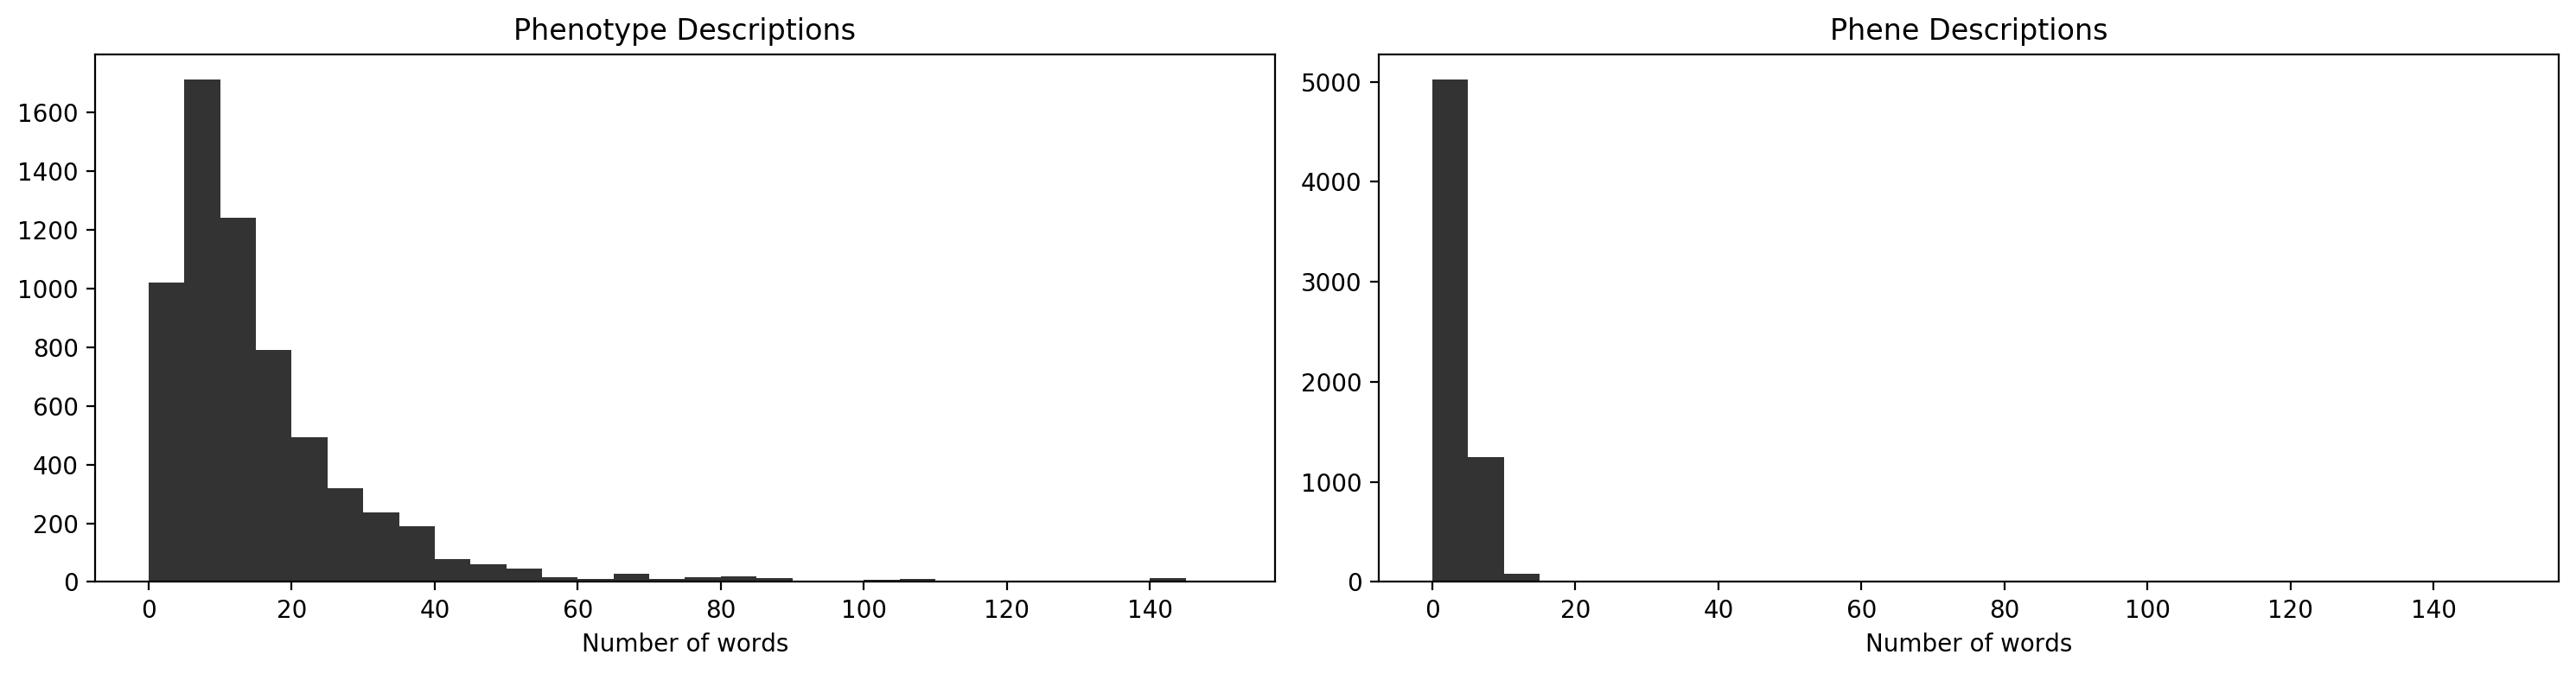

In [26]:
# Plotting distributions of number of words in each class of description.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Phenotype Descriptions")
ax2.set_title("Phene Descriptions")
ax1.set_xlabel("Number of words")
ax2.set_xlabel("Number of words")
x1 = [len(word_tokenize(x)) for x in df["phenotype description"].values]
x2 = [len(word_tokenize(x)) for x in df["atomized statement"].values]
ax1.hist(x1, bins=30, range=(0,150), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
ax2.hist(x2, bins=30, range=(0,150), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
fig.set_size_inches(15,4)
fig.tight_layout()
fig.show()

In [27]:
# Finding the number of unique descriptions in each class of text description.
print(len(pd.unique(df["phenotype description"])))
print(len(pd.unique(df["atomized statement"])))

1952
2682


### Part 2: Ontology Term Annotations
There are several columns in the original dataset which refer to ontology terms, and specify a particular aspect of the EQ statement structure that that particular term refers to. For this dataset we are constructing, we will treat ontology term annotations as a 'bag of terms', and ignore the context of multi-term structured annotations such as EQ statements. Therefore these columns can be combined and any mentioned terms can be combined into a new column (as a bar delimited list). Contex of these terms in their respective ontologies are ignored (more than just leaf terms are retained), because this is handled later when comparing term sets.

In [28]:
# Combining the different components of the EQ statement into a single column.
df["term_ids"] = np.vectorize(concatenate_with_bar_delim)(
    df["primary entity1 ID"], df["primary entity2 ID (optional)"], 
    df["quality ID"], df["PATO Qualifier ID (optional)"], 
    df["secondary_entity1 ID (optional)"], df["secondary entity2 ID (optional)"], 
    df["developmental stage ID (optional)"], df["condition ID (optional)"])
print(df[["term_ids"]].head(15))

                                term_ids
0                GO:0009739|PATO:0002302
1                GO:0009739|PATO:0002302
2                PO:0000003|PATO:0000569
3                PO:0020142|PATO:0000574
4                PO:0000003|PATO:0000569
5                PO:0020142|PATO:0000574
6   PO:0009010|PATO:0001241|PATO:0000460
7   GO:2000014|PATO:0001236|PATO:0000460
8                PO:0000003|PATO:0001834
9                PO:0009010|PATO:0002460
10  GO:0016135|PATO:0001236|PATO:0000460
11               PO:0000003|PATO:0000587
12  GO:0016135|PATO:0001236|PATO:0000460
13               PO:0000003|PATO:0000587
14    PO:0009037|PATO:0000646|PO:0007130


In [29]:
# Organizing the desired information into a standard set of column headers.
df["species"] = df["Species"].apply(to_abbreviation)
df["gene_names"] = np.vectorize(concatenate_with_bar_delim)(
    df["Gene Identifier"], df["gene symbol"], df["allele (optional)"])
df["pmid"] = df["Pubmed ID (optional)"]
print(df[["species","gene_names","pmid"]].head(20))

   species                   gene_names pmid
0      zma            GRMZM2G069028|ns1     
1      zma           NM_001111772.1|ns2     
2      zma            GRMZM2G069028|ns1     
3      zma            GRMZM2G069028|ns1     
4      zma           NM_001111772.1|ns2     
5      zma           NM_001111772.1|ns2     
6      ath              At3g49600|UBP26     
7      ath              At3g49600|UBP26     
8      ath              At3g49600|UBP26     
9      ath              At3g49600|UBP26     
10     mtr  Medtr3g021350|cyp716A12|lha     
11     mtr  Medtr3g021350|cyp716A12|lha     
12     mtr  Medtr3g021180|cyp716A12|lha     
13     mtr  Medtr3g021180|cyp716A12|lha     
14     osa      Os01g0129200|SL1|stl1.1     
15     osa      Os01g0129200|SL1|stl1.1     
16     osa      Os01g0129200|SL1|stl1.1     
17     osa      Os01g0129200|SL1|stl1.1     
18     osa      Os01g0129200|SL1|stl1.1     
19     osa      Os01g0129200|SL1|stl1.1     


In [30]:
# Saving a version that uses the full phenotype descriptions.
df["description"] = df["phenotype description"]
df_subset = df[["species", "gene_names", "description", "term_ids", "pmid"]]
df_subset["term_ids"] = ""
path = os.path.join(OUTPUT_DIR,"ppn_phenotypes.csv")
df_subset.to_csv(path, index=False)

# Saving a version that uses the individual phene descriptions.
df["description"] = df["atomized statement"]
df_subset = df[["species", "gene_names", "description", "term_ids", "pmid"]]
df_subset["term_ids"] = ""
path = os.path.join(OUTPUT_DIR,"ppn_phenes.csv")
df_subset.to_csv(path, index=False)

# Saving a version that includes only the ontology term annotations.
df["description"] = ""
df_subset = df[["species", "gene_names", "description", "term_ids", "pmid"]]
path = os.path.join(OUTPUT_DIR,"ppn_annotations.csv")
df_subset.to_csv(path, index=False)